In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Download data with yfinance
ticker = 'UNHH34.SA'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.download(ticker, start=start_date, end=end_date)
#data.reset_index(inplace=True)
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,log_return
Ticker,UNHH34.SA,UNHH34.SA,UNHH34.SA,UNHH34.SA,UNHH34.SA,
Date,,,,,,
2019-06-19,12.509823,12.509823,12.509823,12.509823,0,0.000000
2019-06-21,12.703470,12.703470,12.703470,12.703470,2800,0.015361
2019-06-24,12.703470,12.703470,12.703470,12.703470,0,0.000000
2019-06-25,12.703470,12.703470,12.703470,12.703470,0,0.000000
2019-06-26,12.703470,12.703470,12.703470,12.703470,0,0.000000


In [6]:
import data_preprocessing as datapre

seq_number = 10
mms, train_data, test_data = datapre.split_data(data, .75)
train_seq, train_label = datapre.create_sequence(train_data, seq_number)
test_seq, test_label = datapre.create_sequence(test_data, seq_number)

In [7]:
import tensorflow as tf

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Input((train_seq.shape[1], train_seq.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(units=6),
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,590 (201.52 KB)

 Trainable params: 51,590 (201.52 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = lstm_model.fit(train_seq, train_label, epochs=40,                  validation_data=(test_seq, test_label), callbacks=[early_stopping])

Epoch 1/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0506 - mean_absolute_error: 0.1483 - val_loss: 0.0181 - val_mean_absolute_error: 0.0979
Epoch 2/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 - mean_absolute_error: 0.0463 - val_loss: 0.0080 - val_mean_absolute_error: 0.0602
Epoch 3/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - mean_absolute_error: 0.0372 - val_loss: 0.0080 - val_mean_absolute_error: 0.0607
Epoch 4/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0028 - mean_absolute_error: 0.0354 - val_loss: 0.0085 - val_mean_absolute_error: 0.0604
Epoch 5/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - mean_absolute_error: 0.0347 - val_loss: 0.0089 - val_mean_absolute_error: 0.0619


In [9]:
test_size = len(test_seq)
test_predicted = lstm_model.predict(test_seq)
test_inverse_predicted = pd.DataFrame(mms.inverse_transform(test_predicted), columns=[f'{name}' for name in data.columns.get_level_values(0) ])
test_inverse_predicted.set_index(data.index[-test_size:], inplace=True)
test_inverse = data.loc[data.index[-test_size:]]

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


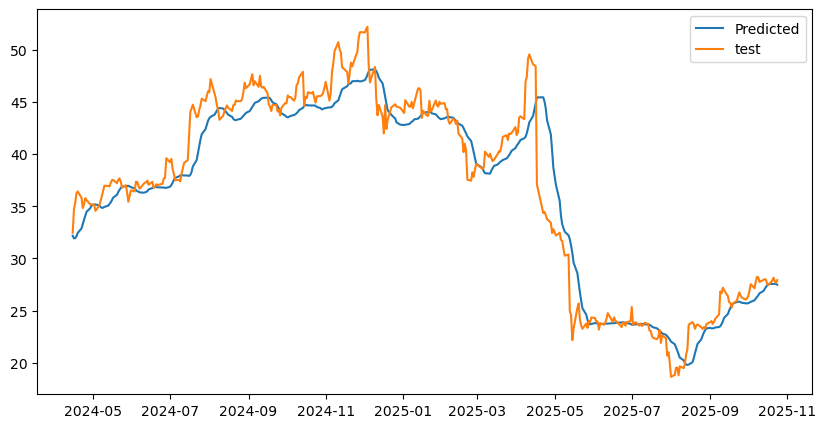

In [10]:
plt.figure(figsize=(10,5))
plt.plot(test_inverse_predicted.index, test_inverse_predicted['Close'], label="Predicted")
plt.plot(test_inverse.index, test_inverse['Close'], label="test")
plt.legend()

In [11]:
lstm_model.evaluate(test_seq, test_label, verbose=2)
lstm_model.save(f"../models/lstm_{ticker}.keras")

13/13 - 0s - 8ms/step - loss: 0.0089 - mean_absolute_error: 0.0619


In [12]:
import utils.date_utils as dtu

next_days = dtu.get_next_workdays(data.index[-1], 10)